## 1. Load the training set and validation set.

In [3]:
%matplotlib inline                                       
# 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
from sklearn.datasets import load_svmlight_file
import scipy
import numpy as np

def load_data(pth, n=None):
    data = load_svmlight_file(pth, n)                    # 使用load_svmlight_file读取libsvm格式的数据集
    return data[0], data[1]


data_train_pth = "C:\\Users\\52402\\jupyter\\a9a.txt"    # 训练集绝对路径
data_valid_pth = "C:\\Users\\52402\\jupyter\\a9a_t.txt"  # 测试机绝对路径

x_train, y_train = load_data(data_train_pth, 123)
x_valid, y_valid = load_data(data_valid_pth, 123)

x_train = x_train.todense()   # 转为稠密矩阵
x_valid = x_valid.todense()

x_1_train = np.ones((x_train.shape[0],1),dtype='float64') # creat [1,1,……,1]^T
x_train = np.concatenate((x_train,x_1_train),axis=1) #m erge x_train and [1,1,……,1]^T

x_1_valid = np.ones((x_valid.shape[0],1),dtype='float64') #creat [1,1,……,1]^T
x_valid = np.concatenate((x_valid,x_1_valid),axis=1) #merge x_valid and [1,1,……,1]^T

y_train = ((y_train+1)/2)  # 把y从（-1，1）转换为（0， 1）
y_valid = ((y_valid+1)/2)
y_train.shape = (y_train.shape[0], 1)
y_valid.shape = (y_valid.shape[0], 1)


## 2. Initialize logistic regression model parameter (you can consider initializing zeros, random numbers or normal distribution). 

In [8]:
w = 2*(np.random.random([x_train.shape[1],1]))-1   #  w参数随机初始化到（-1， 1）之间

## 3.Select the loss function and calculate its derivation.

$$ J（W） = -\frac{1}{n}\left\lgroup\sum_{i=1}^ny_i\log h_w(x_i)+(1-y_i)\log(1-h_w(x_i))\right\rgroup  $$

$$ \frac{\partial J（W）}{\partial W}=\frac{1}{n}\sum_{i=1}^n(h_w(x_i)-y)x_i     $$

## Logistic Regression and MIni-batch Gradient Descent.

In [9]:
import time
import matplotlib.pyplot as plt

def getMiniBatch(num_batch, x, y):         # 按照batch大小，获取mini-batch
    num = x.shape[0]
    for i in range(0, num-num_batch, num_batch): 
        yield x[i: i+num_batch], y[i: i+num_batch], int(i/num_batch)
        

def getRandomBatch(num_batch, x, y):     #  随机取出部分样本
    n_r = np.random.randint(x.shape[0])
    x_batch = x[n_r]
    y_batch = []
    y_batch.append(y[n_r])
    for n in range(num_batch-1):
            n_r = np.random.randint(x.shape[0])
            x_batch = np.concatenate((x_batch, x[n_r]), axis=0)
            y_batch.append(y[n_r])
    
    y_batch = np.array(y_batch)
    y_batch.shape = (num_batch,1)
    return x_batch, y_batch

        
def gradient(x, y, w):           # 计算梯度
    G = 1/x.shape[0] * (x.T.dot(h_w(w, x) - y))
    return G


def h_w(w, x):    #   H function
    h = 1/(1 + np.exp(-x.dot(w)))
    return h


def update_w(w, G, learn_rate): # update w with gradient descent
    w = w - learn_rate * G
    return w


def update_w_Adam(w,s,r,t,G,learn_rate=0.5,decay_rate1=0.9,decay_rate2 = 0.999,mini_number=0.00000001):#Update w parameters
    s = decay_rate1*s + (1-decay_rate1)*G
    r = decay_rate2*r + (1-decay_rate2)*G.T.dot(G)
    s_b = s/(1-np.power(decay_rate1,t))
    r_b = r/(1-np.power(decay_rate2,t))
    w = w - learn_rate*s_b/(np.sqrt(r_b)+mini_number)
    return w,s,r


def get_loss(x,y,w):  # Loss of data set
    h = h_w(w,x)
    loss = -1/x.shape[0] * ( y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h)))
    return loss[0,0]


def predict_result(x, w, threshold):  # Predict y with w and data set
    result = h_w(w, x)
    result[result > threshold] = 1
    result[result < threshold] = 0
    return result


def Accuracy(y_predict, y_valid):  #C alculate the accuracy
    accuracy = (y_predict == y_valid)
    accuracy = np.sum(accuracy) / accuracy.shape[0]
    return accuracy


learn_rate = 0.01    # 学习率
threshold = 0.5      # 阈值
iteration = 3000            # epoch次数
batch_size = 128     # mini-batch大小

# Adam的超参数
s = 0
r = 0
decay_rate1 = 0.9
decay_rate2 = 0.999
mini_number = 0.00000001

axis_x = []
valid_loss = []

start_time = time.time()
for i in range(iteration):                                   # 7.Repeat step 4 to 6 for several times
    x_batch, y_batch = getRandomBatch(batch_size, x_train, y_train)   # 随机取出部分样本

    #  6. Select the appropriate threshold, mark the sample whose predict scores greater than the threshold as positive, on the contrary as negative. Predict under validation set and get the loss L_validation.
    if i % 20 == 0:                                  # 每20次iteration， 记录一次loss并打印一次accuracy
        axis_x.append(i)
        loss = get_loss(x_valid, y_valid, w)                 # 获取模型预测结果的损失值并记录在valid_loss中
        valid_loss.append(loss)
            
        y_predict = predict_result(x_valid, w, threshold)    #  获取模型预测结果
        accuracy = Accuracy(y_predict, y_valid)              # 计算预测结果准确率
            
        print("Iteration: {}    Accuracy: {:.2f}%".format(i, accuracy*100))
        
    #  4. Calculate gradient G toward loss function from partial samples.
    G = gradient(x_batch, y_batch, w)

    # 5. Use the SGD optimization method to update the parametric model
#       w = update_w(w, G, learn_rate)
        
    # 5. Use the Adam optimization method to update the parametric model
    w, s, r = update_w_Adam(w, s, r, i+1, G, learn_rate, decay_rate1, decay_rate2, mini_number)
        
        
total_time = time.time()-start_time                          #  计算完成所有iteration所需时间
print("total_time: {:.4f} second".format(total_time))

Iteration: 0    Accuracy: 62.39%
Iteration: 20    Accuracy: 68.72%
Iteration: 40    Accuracy: 72.80%
Iteration: 60    Accuracy: 75.33%
Iteration: 80    Accuracy: 76.61%
Iteration: 100    Accuracy: 77.50%
Iteration: 120    Accuracy: 77.92%
Iteration: 140    Accuracy: 78.15%
Iteration: 160    Accuracy: 78.42%
Iteration: 180    Accuracy: 78.69%
Iteration: 200    Accuracy: 78.93%
Iteration: 220    Accuracy: 79.15%
Iteration: 240    Accuracy: 79.38%
Iteration: 260    Accuracy: 79.49%
Iteration: 280    Accuracy: 79.62%
Iteration: 300    Accuracy: 79.85%
Iteration: 320    Accuracy: 79.96%
Iteration: 340    Accuracy: 80.18%
Iteration: 360    Accuracy: 80.34%
Iteration: 380    Accuracy: 80.62%
Iteration: 400    Accuracy: 80.84%
Iteration: 420    Accuracy: 81.01%
Iteration: 440    Accuracy: 80.95%
Iteration: 460    Accuracy: 81.16%
Iteration: 480    Accuracy: 81.25%
Iteration: 500    Accuracy: 81.48%
Iteration: 520    Accuracy: 81.57%
Iteration: 540    Accuracy: 81.71%
Iteration: 560    Accuracy

## 7. Drawing graph of L_validation with the number of iterations.

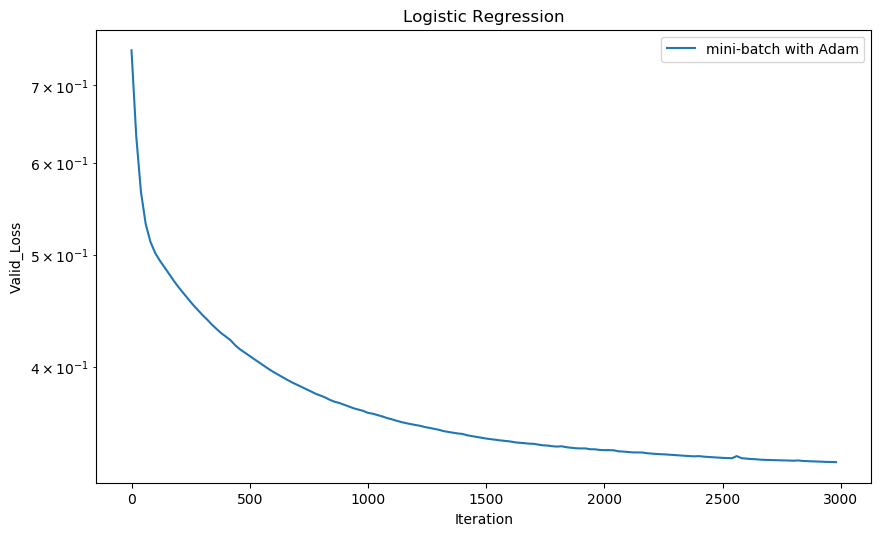

In [10]:
# marker数据点样式，linewidth线宽，linestyle线型样式，color颜色
# plt.plot(x, y, marker="*", linewidth=3, linestyle="--", color="orange")
plt.figure(figsize=(10,6),dpi=100)
plt.yscale('log')        # 改变y轴刻度
plt.plot(axis_x, valid_loss, label = 'mini-batch with Adam')
plt.title("Logistic Regression")
plt.xlabel("Iteration")
plt.ylabel("Valid_Loss")
# 设置图例
plt.legend()